In [1]:
#IMPORT NEEDED LIBRARIES

from tensorflow.keras.datasets import cifar10
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# LOAD THE CIFAR 10 DATASET AND NORMALIZE IT

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# PREPARE VALIDATION DATA

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print('Validation set shape:',X_valid.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training set shape: (40000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)


In [8]:
class Conv2DBatchNormReLU(tf.keras.layers.Layer):
    def __init__(self, filters, l2=2.5e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            use_bias=False,
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_regularizer=tf.keras.regularizers.l2(l2),
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9,
            beta_regularizer=tf.keras.regularizers.l2(l2),
            gamma_regularizer=tf.keras.regularizers.l2(l2)
        )

    def call(self, inputs, training=False):
        x = self.conv2d(inputs)
        x = self.batch_norm(x, training=training)
        return tf.nn.relu(x)


class ResNet9Block(tf.keras.layers.Layer):
    def __init__(self, filters, l2=2.5e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv_bn_relu_1 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.conv_bn_relu_2 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.downsample = tf.keras.layers.Conv2D(filters=filters,
                                                 kernel_size=1,
                                                 strides=2,
                                                 padding='SAME',
                                                 use_bias=False,
                                                 kernel_regularizer=tf.keras.regularizers.l2(l2))
        self.batch_norm = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9,
                                                              beta_regularizer=tf.keras.regularizers.l2(l2),
                                                              gamma_regularizer=tf.keras.regularizers.l2(l2))
        self.max_pool2d = tf.keras.layers.MaxPool2D(pool_size=2)

    def call(self, inputs, training=False):
        shortcut = self.downsample(inputs)
        shortcut = self.batch_norm(shortcut, training=training)

        x = self.conv_bn_relu_1(inputs, training=training)
        x = self.max_pool2d(x)
        x = self.conv_bn_relu_2(x, training=training)

        return tf.nn.relu(x + shortcut)



def ResNet9(input_shape=(32, 32, 3), num_classes=10, l2=2.5e-4):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2DBatchNormReLU(64, l2=l2)(inputs)
    x = ResNet9Block(128, l2=l2)(x)

    x = Conv2DBatchNormReLU(256, l2=l2)(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = ResNet9Block(512, l2=l2)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(
        num_classes,
        activation="softmax",
        use_bias=False,
        kernel_regularizer=tf.keras.regularizers.l2(l2),
        kernel_initializer=tf.keras.initializers.HeUniform(),
    )(x)

    return tf.keras.Model(inputs, x, name="ResNet9")

In [9]:
# BUILD THE MODEL

model = ResNet9(input_shape=(32, 32, 3), num_classes=10)
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cifar_resnet9_model.keras', monitor='val_loss', save_best_only=True)


Model: "ResNet9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_batch_norm_re_lu_3            │ (None, 32, 32, 64)          │           1,984 │
│ (Conv2DBatchNormReLU)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net9_block_1 (ResNet9Block)      │ (None, 16, 16, 128)         │         230,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_batch_norm_re_lu_6            │ (None, 16, 16, 256)         │         295,936 │
│ (Conv2DBatchNormReLU)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net9_block_2 (ResNet9Block)      │ (None, 4, 4, 512)           │       3,676,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,120 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,210,112 (16.06 MB)

 Trainable params: 4,205,632 (16.04 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [10]:
# COMPILE THE MODEL AND RUN IT.

model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping,model_checkpoint]
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.4925 - loss: 2.7408 - val_accuracy: 0.5902 - val_loss: 2.0559
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.7111 - loss: 1.6501 - val_accuracy: 0.6866 - val_loss: 1.6101
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.7730 - loss: 1.3306 - val_accuracy: 0.7187 - val_loss: 1.4238
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8147 - loss: 1.1405 - val_accuracy: 0.7624 - val_loss: 1.2320
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8432 - loss: 1.0076 - val_accuracy: 0.7581 - val_loss: 1.2241
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8624 - loss: 0.9194 - val_accuracy: 0.7943 - val_loss: 1.1109
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8863 - loss: 0.8281 - val_accuracy: 0.8179 - val_loss: 1.0431
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9061 - loss: 0

<Axes: >

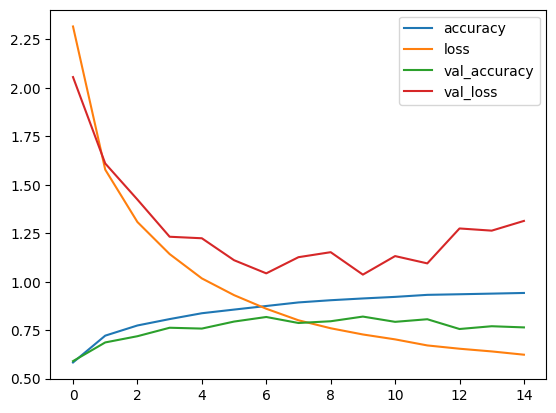

In [11]:
# VISUALIZE THE PERFORMANCE OF THE MODEL

pd.DataFrame(history.history).plot()

In [12]:
# TESTING THE MODEL WITH TEST DATA AND PREPARE CLASSIFICATION REPORT (PRECISION , RECALL, F1-SCORE)

scores = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
target = [class_names[i].format(i) for i in range(10)]

print("\n\nTesting Accuracy :",scores[1],"\n")
print(classification_report(y_test.flatten(), np.argmax(y_pred, axis=1), target_names=target))

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8135 - loss: 1.0614
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


Testing Accuracy : 0.8136000037193298 

              precision    recall  f1-score   support

    airplane       0.87      0.79      0.83      1000
  automobile       0.88      0.94      0.90      1000
        bird       0.70      0.80      0.74      1000
         cat       0.85      0.44      0.58      1000
        deer       0.74      0.88      0.80      1000
         dog       0.75      0.77      0.76      1000
        frog       0.83      0.89      0.86      1000
       horse       0.83      0.88      0.85      1000
        ship       0.90      0.86      0.88      1000
       truck       0.85      0.91      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



Reference : https://github.com/JonathanRayner/ResNet9/blob/master/resnet9_tensorflow.ipynb